In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter

from torch.utils.data import Subset
import pickle

In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [3]:
dataset = datasets.EuroSAT(root="./data", transform=transform, download=True)

In [4]:
# Get class labels
class_names = dataset.classes
print("EuroSAT Classes:", class_names)

EuroSAT Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [5]:
# 📊 2. Basic Info
print(f"Total number of images: {len(dataset)}")
print(f"Number of classes: {len(class_names)}")

Total number of images: 27000
Number of classes: 10


In [6]:
labels = [dataset[i][1] for i in range(len(dataset))]
label_counts = Counter(labels)

In [10]:
# create a list of indices for each class
class_indices = {label: [] for label in range(len(class_names))}
for idx, label in enumerate(labels):
    class_indices[label].append(idx)

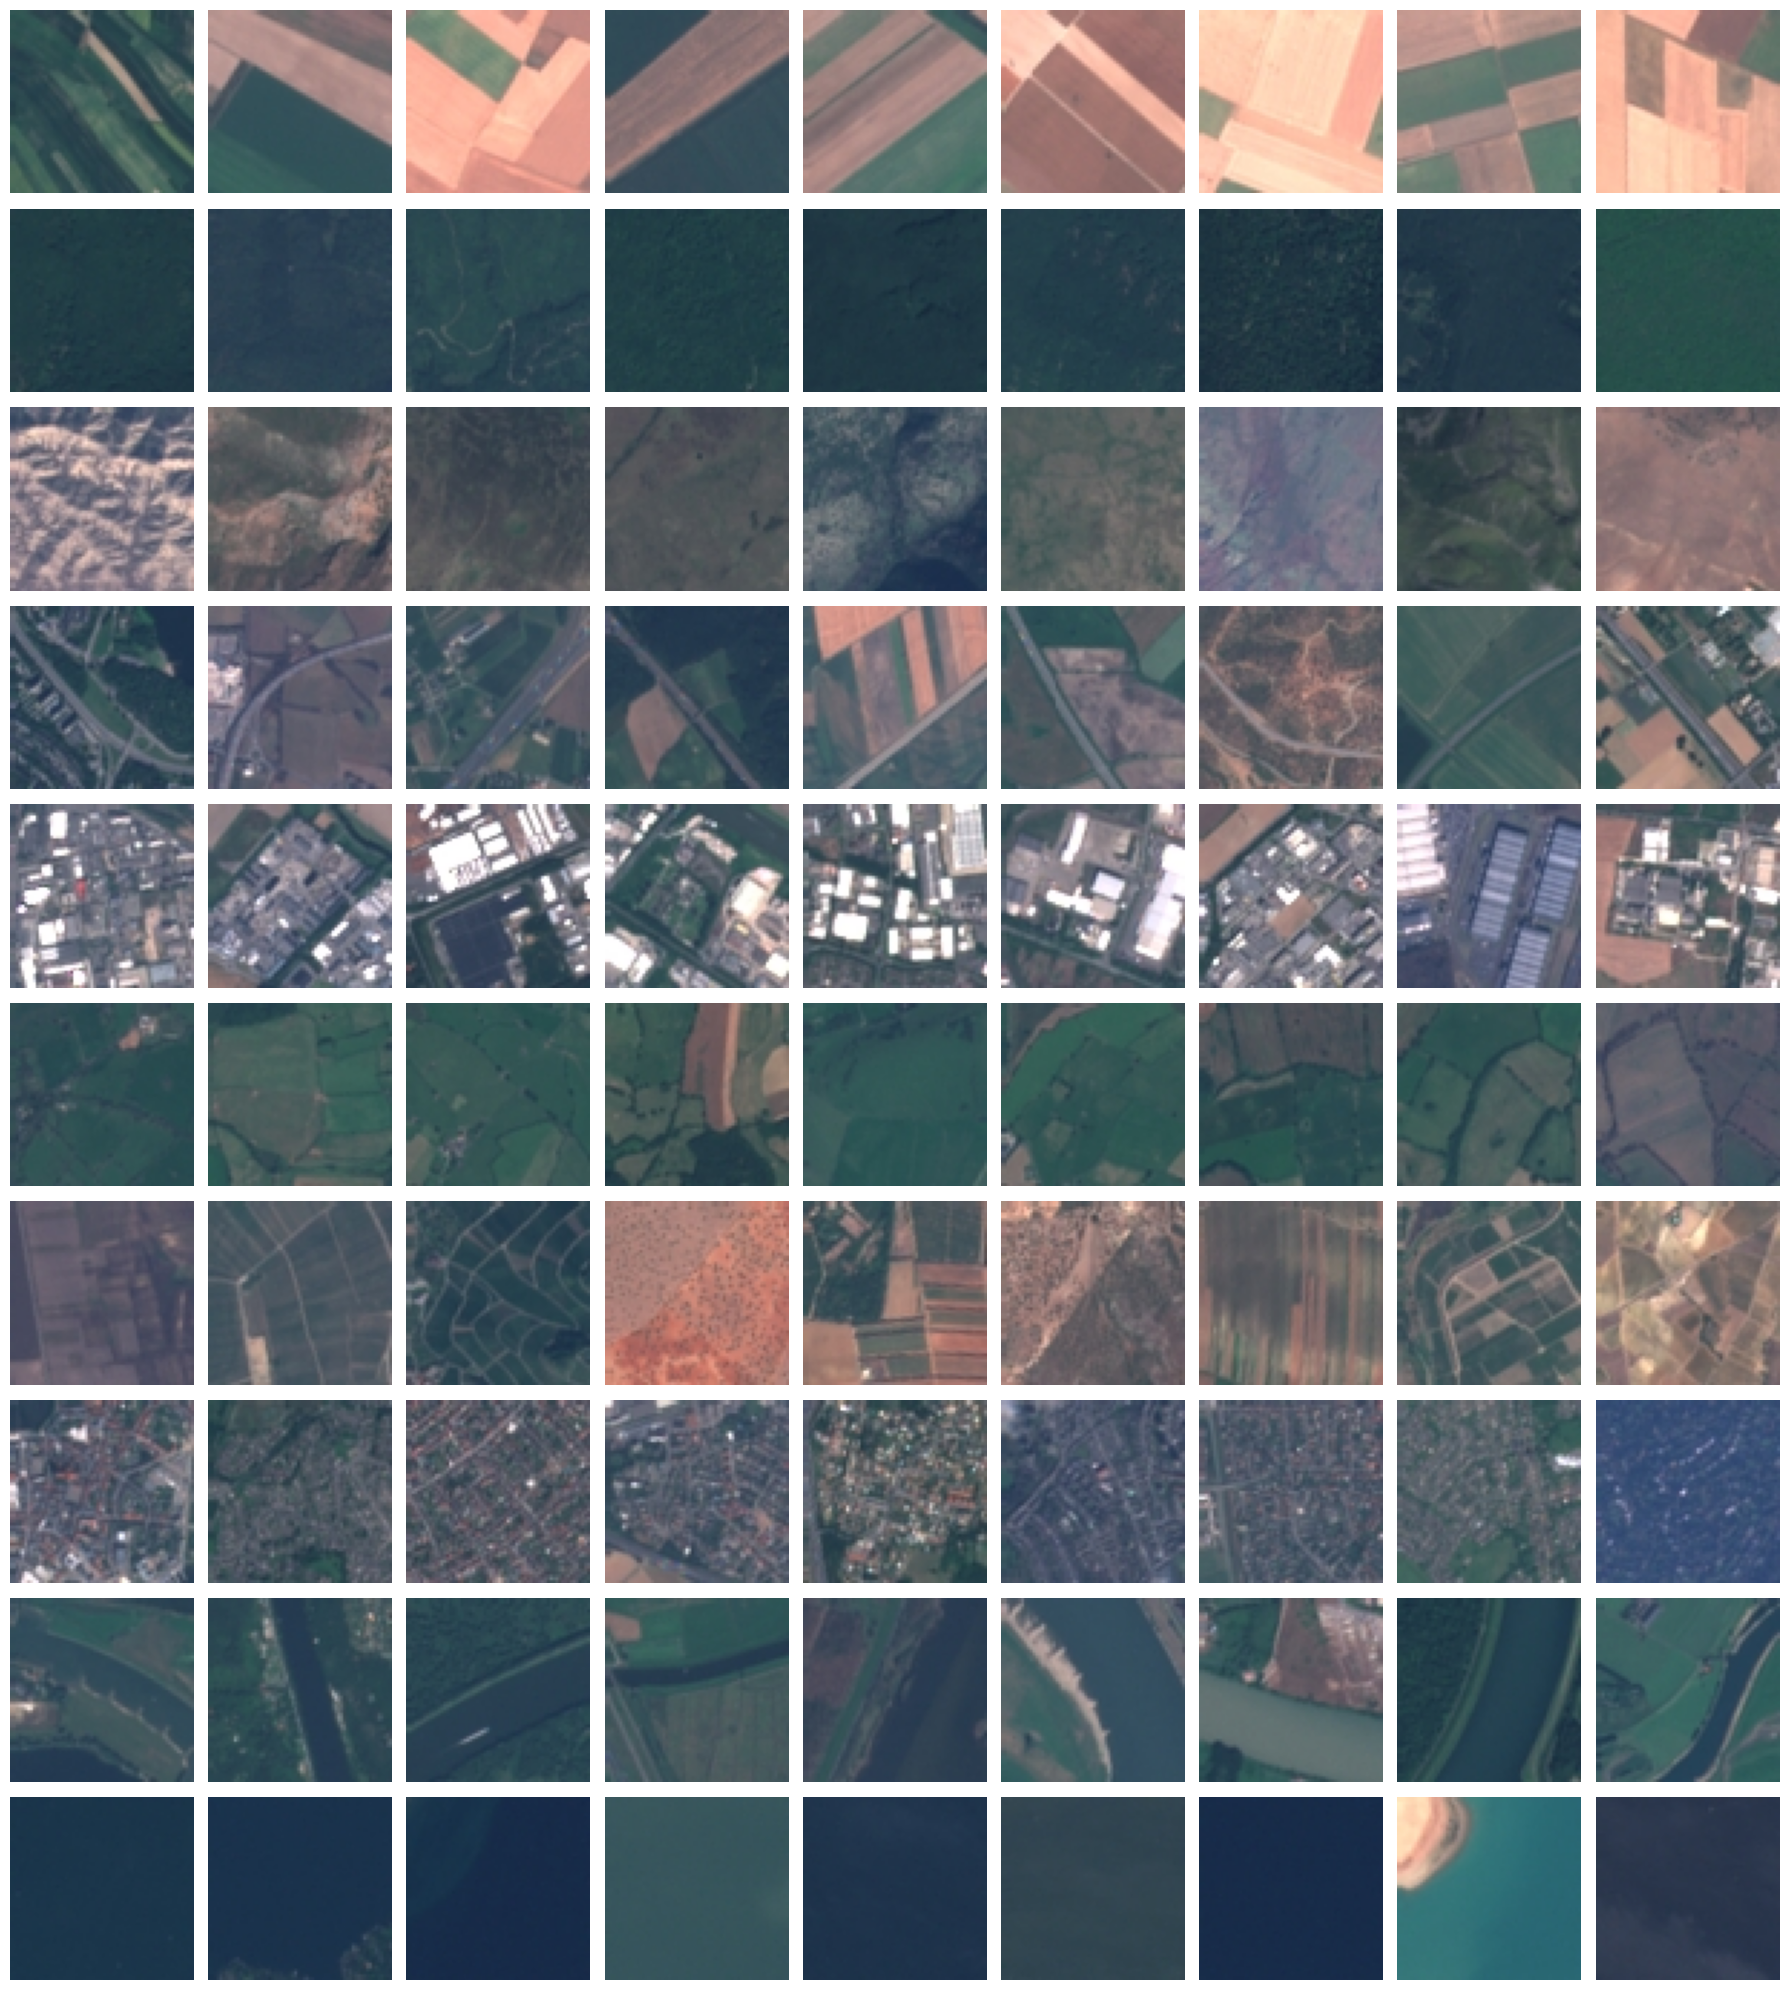

In [16]:
num_classes = len(class_names)
num_images_per_class = 9
fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class * 2, num_classes * 2))
for label in range(num_classes):
    indices = np.random.choice(class_indices[label], num_images_per_class, replace=False)
    for i, idx in enumerate(indices):
        image, _ = dataset[idx]
        axes[label, i].imshow(image.permute(1, 2, 0))
        axes[label, i].axis('off')
        if i == 0:
            axes[label, i].set_ylabel(class_names[label], rotation=0, labelpad=20)

plt.tight_layout()
plt.show()

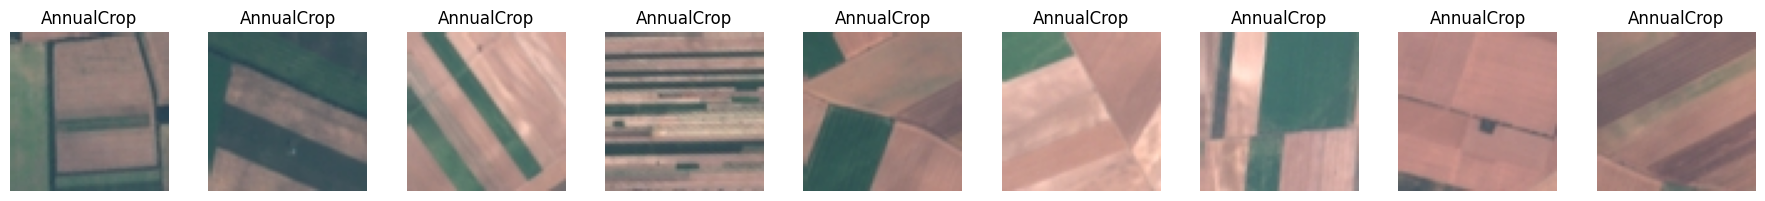

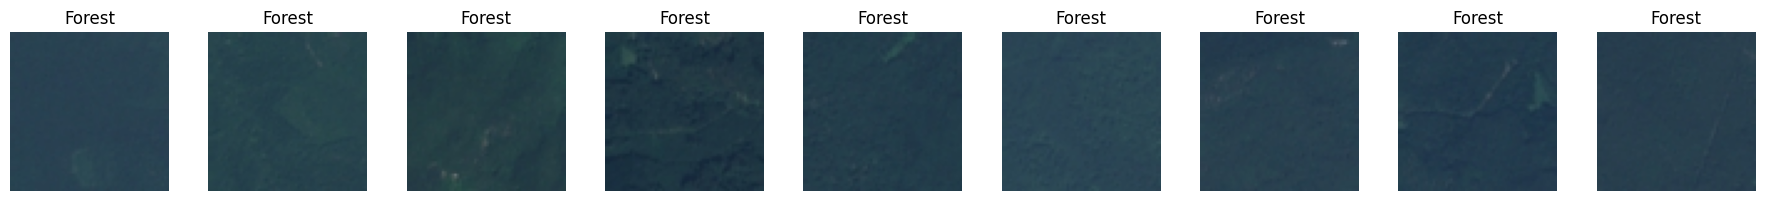

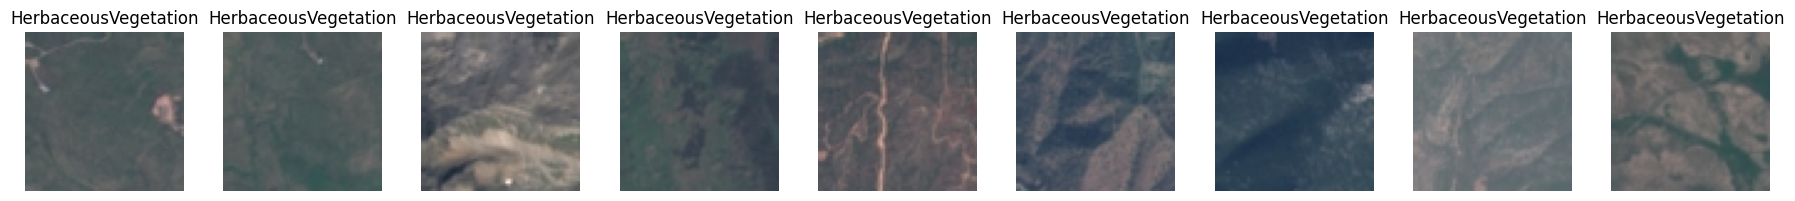

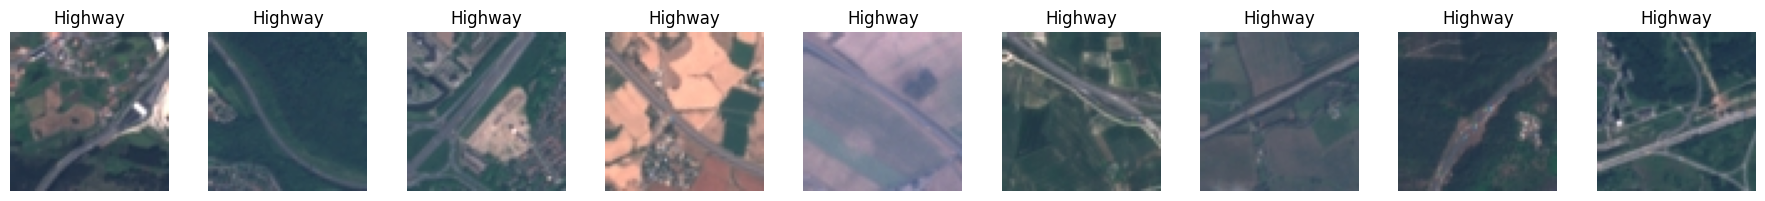

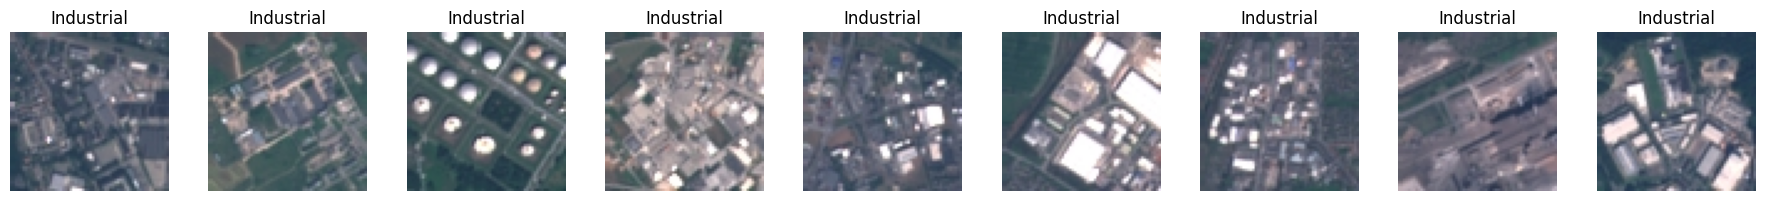

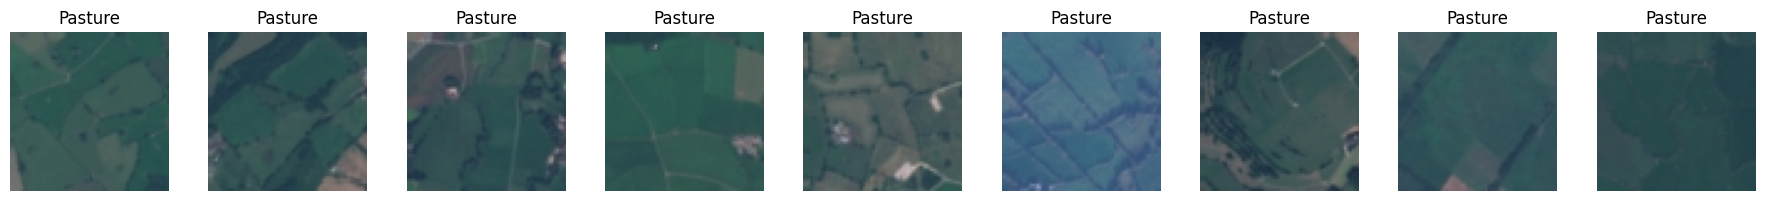

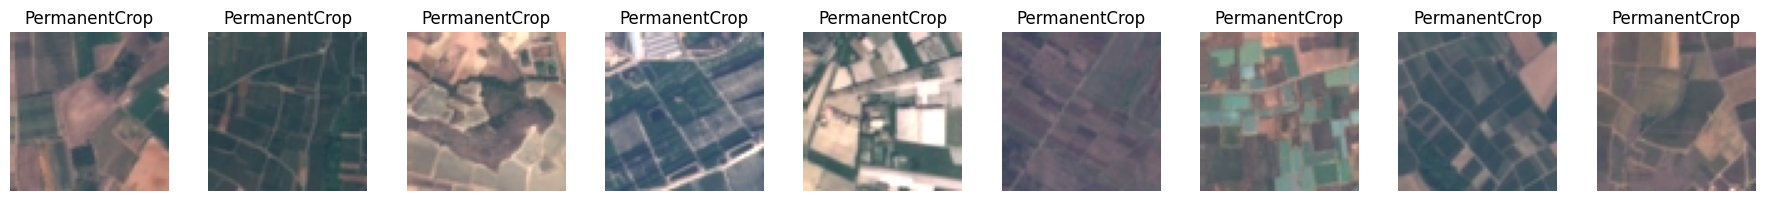

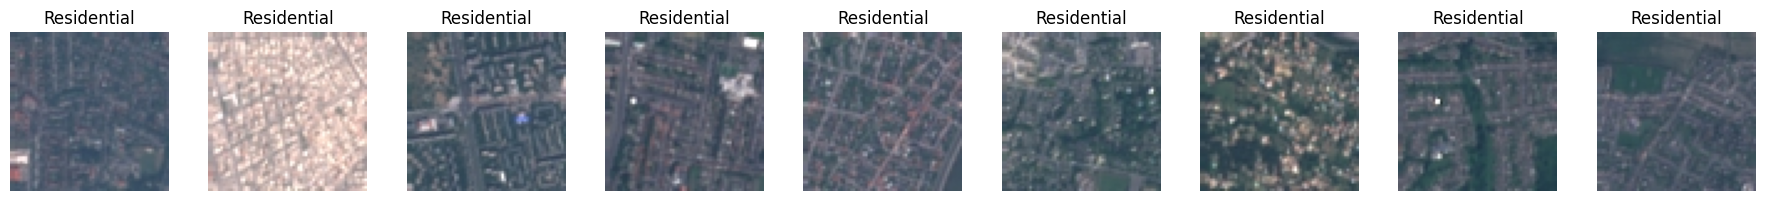

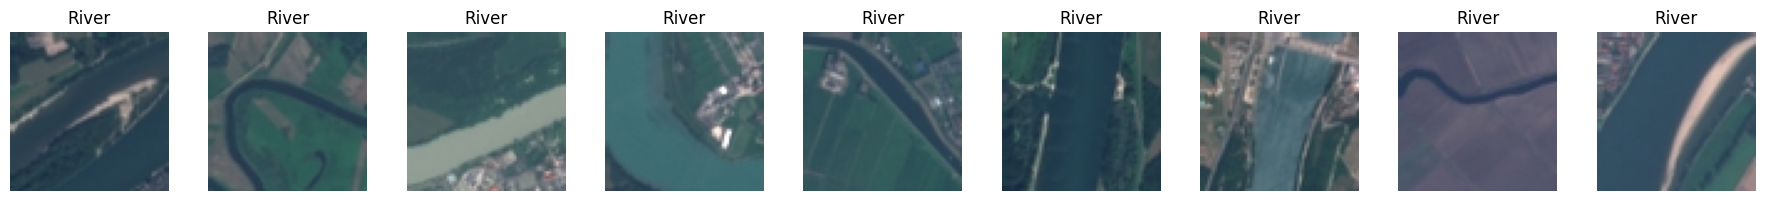

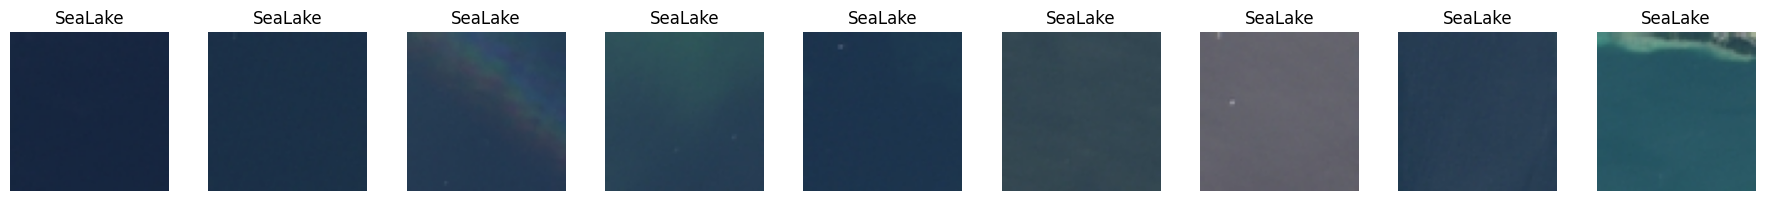

In [17]:
# create a grid of 9 x 9 images for each class
# each label represented by a 1 x 9 grid
# take random from class_indices
# add the class names as the title of each row

for label in range(num_classes):
    indices = np.random.choice(class_indices[label], num_images_per_class, replace=False)
    fig, axes = plt.subplots(1, num_images_per_class, figsize=(num_images_per_class * 2, 2))
    for i, idx in enumerate(indices):
        image, _ = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].axis('off')
        axes[i].set_title(class_names[label])
    plt.tight_layout()
    plt.show()
        
#add the class names as the title of each row
#plt.suptitle("EuroSAT Dataset Sample Images by Class", fontsize=16)
#plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.1)
#plt.show()

#

In [7]:
# Convert to readable format
class_counts = {class_names[i]: label_counts[i] for i in range(len(class_names))}
for cls, count in class_counts.items():
    print(f"{cls:20s}: {count} images")

AnnualCrop          : 3000 images
Forest              : 3000 images
HerbaceousVegetation: 3000 images
Highway             : 2500 images
Industrial          : 2500 images
Pasture             : 2000 images
PermanentCrop       : 2500 images
Residential         : 3000 images
River               : 2500 images
SeaLake             : 3000 images


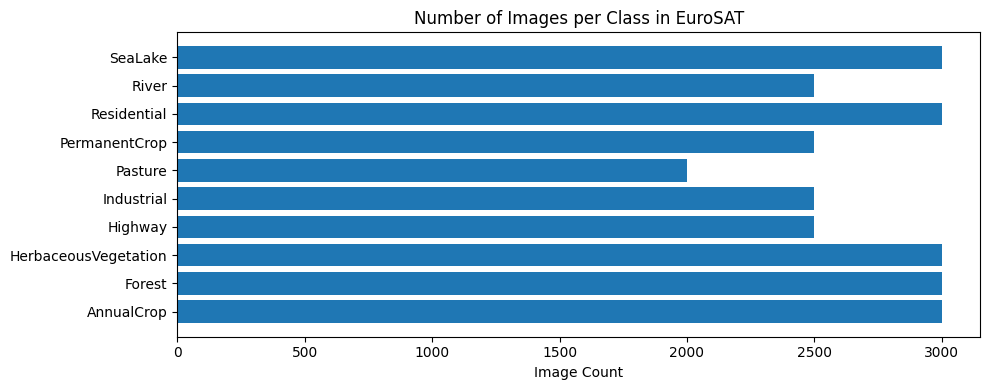

In [21]:
#plt.figure(figsize=(10, 4))
#plt.bar(class_counts.keys(), class_counts.values())
#plt.title("Number of Images per Class in EuroSAT")
#plt.ylabel("Image Count")
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show()

# make the plot above horizontal
plt.figure(figsize=(10, 4))
plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.title("Number of Images per Class in EuroSAT")
plt.xlabel("Image Count")
plt.tight_layout()
plt.show()

In [18]:
# print class dictionary
class_dict = {i: class_names[i] for i in range(len(class_names))}
print("Class Dictionary:", class_dict)

Class Dictionary: {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [ ]:
# create a function that takes an index and returns the image and label, showing in matplotlib
def show_image_index(index):
    image, label = dataset[index]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')
    plt.show()

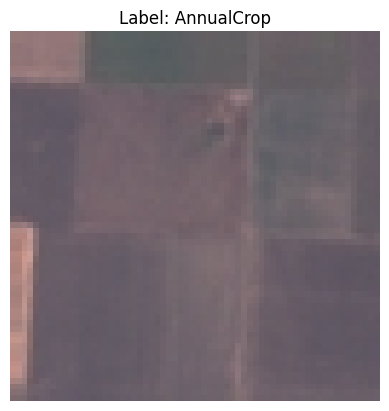

In [20]:
show_image_index(0)  # Show the first image

## Train Test Split

In [22]:
#return the indices of the train and test sets
def get_split_indices():
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
    return split['train'], split['test']

In [23]:
train_indices, test_indices = get_split_indices()

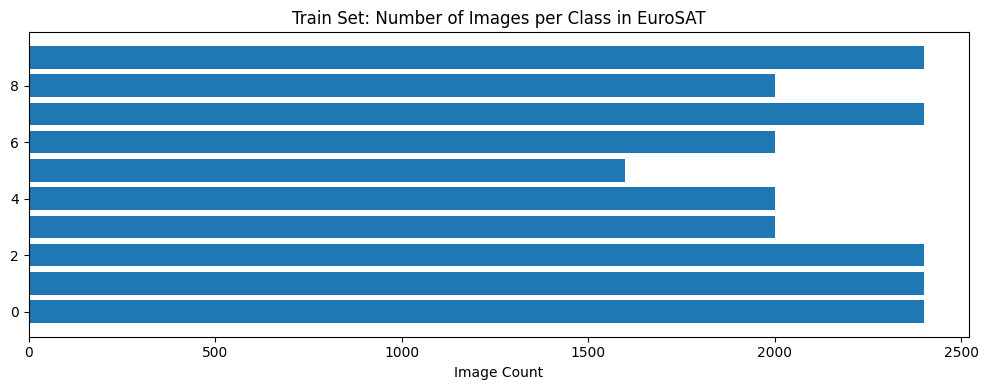

In [25]:
# visualize the train label distribution
train_labels = [dataset[i][1] for i in train_indices]
train_label_counts = Counter(train_labels)
plt.figure(figsize=(10, 4))
plt.barh(list(train_label_counts.keys()), list(train_label_counts.values()))
plt.title("Train Set: Number of Images per Class in EuroSAT")
plt.xlabel("Image Count")
plt.tight_layout()
plt.show()

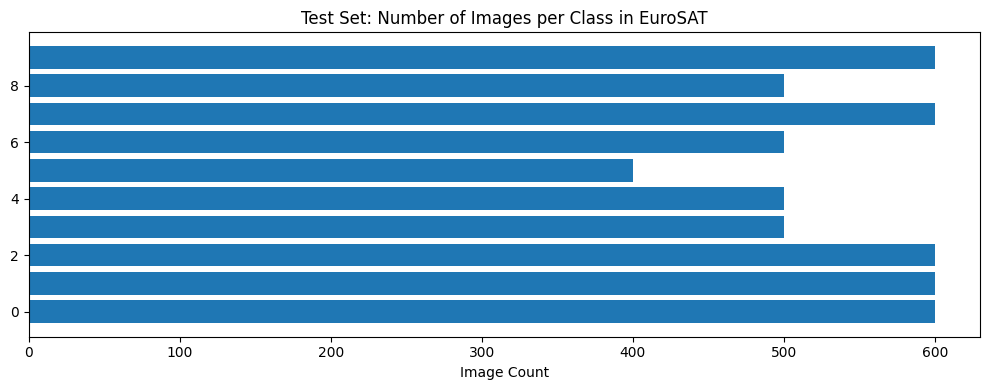

In [26]:
# visualize the test label distribution
test_labels = [dataset[i][1] for i in test_indices]
test_label_counts = Counter(test_labels)
plt.figure(figsize=(10, 4))
plt.barh(list(test_label_counts.keys()), list(test_label_counts.values()))
plt.title("Test Set: Number of Images per Class in EuroSAT")
plt.xlabel("Image Count")
plt.tight_layout()
plt.show()

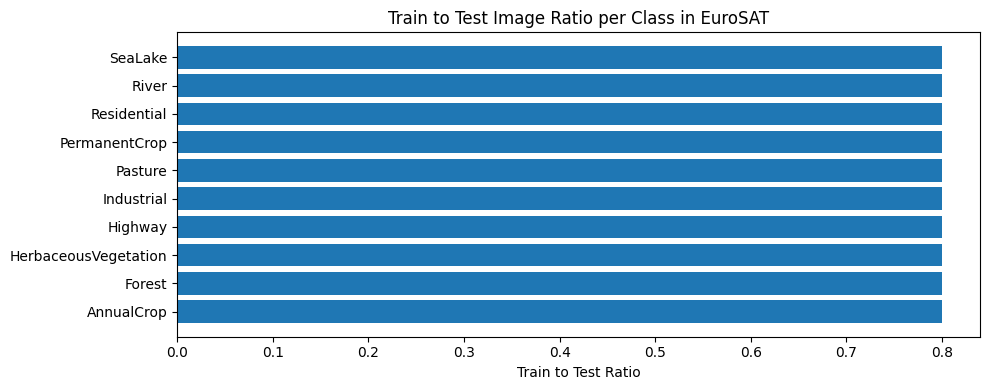

In [27]:
# get the ratio of train to test images for each class
train_counts = np.array([train_label_counts[i] for i in range(len(class_names))])
test_counts = np.array([test_label_counts[i] for i in range(len(class_names))])

ratios = train_counts / (train_counts + test_counts)
plt.figure(figsize=(10, 4))
plt.barh(list(class_names), ratios)
plt.title("Train to Test Image Ratio per Class in EuroSAT")
plt.xlabel("Train to Test Ratio")
plt.tight_layout()
plt.show()

## Load Model and Show accuracy

In [37]:
from utils import BayesianCNN1FC
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoDiagonalNormal

In [43]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist

In [44]:
class BayesianCNN(PyroModule):
    def __init__(self):
        super().__init__()

        # Bayesian Conv2d layer 1
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 1.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 1.).expand([32]).to_event(1))

        # Bayesian Conv2d layer 2
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(0., 1.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 1.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer (output layer)
        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, 10)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([10, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([10]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))   # -> (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 16, 16)
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)  # No intermediate layer

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits

In [57]:
#saved_model_dict = torch.load("pyro_result/mymodel.pth", weights_only=False)
#model.load_state_dict(saved_model_dict['model'])
#mean_field_guide = saved_model_dict['guide']
pyro.get_param_store().load("pyro_result/mymodelparams.pth")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.distributions.constraints._Real was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.distributions.constraints._Real])` or the `torch.serialization.safe_globals([torch.distributions.constraints._Real])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [58]:
# load the model and redo the inference
#pyro.load_state_dict("pyro_result/mymodelparams.pth")

pyro.get_param_store().load('pyro_result/mymodelparams.pth')

model = BayesianCNN()
model.load_state_dict(torch.load('pyro_result/bayesian_cnn_10.pth'))

mean_field_guide = AutoDiagonalNormal(model)
mean_field_guide.load_state_dict(torch.load('pyro_result/mean_field_guide.pth'))

model.eval()
# Re-run the inference with the loaded model
predictive = Predictive(model, guide=mean_field_guide, num_samples=5,
                        return_sites=["_RETURN"])
all_preds = []
all_labels = []
for x_batch, y_batch in tqdm(test_loader):
    batch_preds = predictive(x_batch)["_RETURN"]  # shape: (num_samples, batch_size, ...)
    batch_preds = torch.softmax(batch_preds, dim=-1)
    mean_preds = batch_preds.float().mean(dim=0).squeeze()  # shape: (batch_size, num_classes)
    mean_preds = mean_preds.argmax(dim=1)  # shape: (batch_size,)
    all_preds.append(mean_preds)
    all_labels.append(y_batch)

# Concatenate along the batch dimension
all_preds = torch.cat(all_preds, dim=0)   # shape: (total_test_samples, ...)
all_labels = torch.cat(all_labels, dim=0) # shape: (total_test_samples, ...)
# Calculate accuracy
accuracy = metrics.accuracy_score(all_labels.numpy(), all_preds.numpy())
print(f"Test Accuracy after loading model: {accuracy:.4f}")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.distributions.constraints._Real was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.distributions.constraints._Real])` or the `torch.serialization.safe_globals([torch.distributions.constraints._Real])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.